# Simulations for 1D Convolutions 

In [1]:
# setup
import numpy as np, pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
from utils import *
import dill

%matplotlib inline
%load_ext autoreload
%autoreload 2

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 16,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
    'font.family':"sans-serif",
   'font.sans-serif':'Arial',
   'text.usetex': False,
   }

rcParams.update(params)
plt.style.use('dark_background')

C:\Python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


## Synthetic Data

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

n = 1000 # number of samples
d = 20 # size of each input
pattern = [-1, 1, -1, 1, -1, 1, -1]

y = np.random.randint(0, 2, (n, 1))
X = 2*np.random.random((n, d))-1

positive_count = 0
negative_count = 0

for i in range(n):
    if y[i]==1:
        positive_count += 1
        pos = np.random.randint(0, d-len(pattern))
        X[i][pos:pos+len(pattern)] = pattern
    else:
        negative_count += 1
        
print("Num of positive examples:", positive_count, "- Num of negative examples:", negative_count)

# One-hot encode the labels
one_hot  = OneHotEncoder()
y_ = one_hot.fit_transform(y).toarray()

# Test-train split
data = X_train, X_valid, y_train, y_valid = train_test_split(X, y_, test_size=0.2)

Num of positive examples: 489 - Num of negative examples: 511


## Network

In [23]:
def general_network(data, num_channels=1, verbose=True, batches=1500, print_every=100, filter_size=5,
                    pool_to=1, return_weights=False, reg_kind=None, reg_value=None, kind='fully_connected'):
    
    tf.reset_default_graph()
    # input
    X_train, X_valid, y_train, y_valid = data
    d = X_train.shape[1]

    # placeholders
    x = tf.placeholder(tf.float32, [None, d])
    y_ = tf.placeholder(tf.float32, [None, 2])

    # weights
    if kind=='fully_connected':
        W_1 = get_variable([d, d*num_channels])
        b_1 = get_variable([d*num_channels])
    elif kind=='convolutional':
        W_1 = get_variable([filter_size, 1, num_channels])
        b_1 = get_variable([num_channels])   
    else:
        raise ValueError('Invalid kind of neural network')
    W_fc2 = get_variable([pool_to*num_channels, 2])
    b_fc2 = get_variable([2])
    
    # network
    if kind=='fully_connected':
        h = tf.nn.relu(tf.matmul(x, W_1) + b_1)
    elif kind=='convolutional':
        x_reshaped = tf.reshape(x, [-1, d, 1])
        h = tf.nn.conv1d(x_reshaped, W_1, 1, "SAME")
        
    h = tf.reshape(h, [-1, d*num_channels, 1, 1])
    h = tf.nn.max_pool(h, [1, d/pool_to, 1, 1], [1, d/pool_to, 1, 1], padding='SAME')
    h = tf.reshape(h, [-1, pool_to*num_channels])
    y = tf.matmul(h, W_fc2) + b_fc2

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    if kind=='fully_connected':
        loss = regularize(loss, W_1, reg_kind, reg_value)
    train_step = tf.train.AdamOptimizer(0.003).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(batches):
            train_step.run(feed_dict={x: X_train, y_: y_train})
            if i%print_every==0:
                accuracy_train = accuracy.eval(feed_dict={x: X_train, y_: y_train})
                accuracy_valid = accuracy.eval(feed_dict={x: X_valid, y_: y_valid})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
        
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_1))
        
    return return_values

In [63]:
_, _, weights = general_network(data, kind='fully_connected', reg_kind='DZ+L1', reg_value=[10,0.5], return_weights=True)

Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.525 Valid acc: 0.505
Train acc: 0.6225 Valid acc: 0.575
Train acc: 0.67625 Valid acc: 0.715
Train acc: 0.76375 Valid acc: 0.755
Train acc: 0.8125 Valid acc: 0.79
Train acc: 0.835 Valid acc: 0.805
Train acc: 0.86375 Valid acc: 0.82
Train acc: 0.89375 Valid acc: 0.835
Train acc: 0.92125 Valid acc: 0.91
Train acc: 0.93875 Valid acc: 0.91
Train acc: 0.96125 Valid acc: 0.925


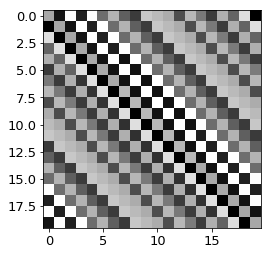

In [64]:
plt.imshow(weights, cmap='gray', vmin=np.min(weights), vmax=np.max(weights))

In [35]:
_, _, weights = general_network(data, kind='convolutional', filter_size=1, return_weights=True)

Train acc: 0.48125 Valid acc: 0.52
Train acc: 0.48125 Valid acc: 0.52
Train acc: 0.48125 Valid acc: 0.52
Train acc: 0.65875 Valid acc: 0.665
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.51875 Valid acc: 0.48
Train acc: 0.94125 Valid acc: 0.955
Train acc: 0.90875 Valid acc: 0.925
Train acc: 0.8675 Valid acc: 0.88
Train acc: 0.845 Valid acc: 0.855
Train acc: 0.8325 Valid acc: 0.845
Train acc: 0.82625 Valid acc: 0.845


# Large Scale Simulations

### Fully-Connected

Varying both the L1 and the DZ

In [108]:
l1s = [0, 0.2, 0.5, 1]
dzs = [0, 1, 2, 5, 10, 20, 50, 100]
iters = 10

trains = np.zeros((len(l1s), len(dzs), iters))
vals = np.copy(trains)
weights = list()

for i, l1 in enumerate(l1s):
    for j, dz in enumerate(dzs):
        for k in range(iters):
            train, val, weight = general_network(data, kind='fully_connected', 
                                                  reg_kind='DZ+L1', reg_value=[l1,dz], 
                                                  verbose=False,
                                                  return_weights=True)
            print(len(weights),':',i,j,k,'-->',train,val)
            trains[i,j,k] = train
            vals[i,j,k] = val
            weights.append(weight)

0 : 0 0 0 --> 1.0 0.99
1 : 0 0 1 --> 0.97 0.965
2 : 0 0 2 --> 0.8625 0.62
3 : 0 0 3 --> 0.98375 0.98
4 : 0 0 4 --> 0.9075 0.67
5 : 0 0 5 --> 1.0 0.98
6 : 0 0 6 --> 0.99125 0.99
7 : 0 0 7 --> 0.98625 0.96
8 : 0 0 8 --> 0.99875 0.99
9 : 0 0 9 --> 0.82625 0.665
10 : 0 1 0 --> 0.99625 0.99
11 : 0 1 1 --> 0.985 0.985
12 : 0 1 2 --> 0.585 0.53
13 : 0 1 3 --> 0.99 0.99
14 : 0 1 4 --> 0.99125 0.99
15 : 0 1 5 --> 0.69625 0.595
16 : 0 1 6 --> 0.99 0.98
17 : 0 1 7 --> 0.76625 0.69
18 : 0 1 8 --> 0.99875 0.99
19 : 0 1 9 --> 0.7825 0.62
20 : 0 2 0 --> 0.98875 0.965
21 : 0 2 1 --> 0.99375 0.99
22 : 0 2 2 --> 0.65875 0.59
23 : 0 2 3 --> 0.98875 0.99
24 : 0 2 4 --> 0.98625 0.94
25 : 0 2 5 --> 0.97625 0.95
26 : 0 2 6 --> 0.98875 0.955
27 : 0 2 7 --> 0.9875 0.995
28 : 0 2 8 --> 0.98375 0.99
29 : 0 2 9 --> 0.98125 0.985
30 : 0 3 0 --> 0.685 0.6
31 : 0 3 1 --> 0.99 0.995
32 : 0 3 2 --> 0.9825 0.98
33 : 0 3 3 --> 0.97 0.955
34 : 0 3 4 --> 0.97 0.955
35 : 0 3 5 --> 0.62875 0.61
36 : 0 3 6 --> 0.98125 0.985


### Convolutions

In [183]:
filter_sizes = [1,3,5,7,9,11,13,15,17,19]
iters = 10

trains_conv = np.zeros((len(filter_sizes), iters))
vals_conv = np.copy(trains_conv)
weights_conv = list()

for i, filter_size in enumerate(filter_sizes):
    for j in range(iters):
        train, val, weight = general_network(data, kind='convolutional', filter_size=filter_size,
                                              verbose=False,
                                              return_weights=True)
        print(len(weights_conv),':',filter_size,j,'-->',train,val)
        trains_conv[i,j] = train
        vals_conv[i,j] = val
        weights_conv.append(weight)

0 : 1 0 --> 0.80875 0.835
1 : 1 1 --> 0.82625 0.845
2 : 1 2 --> 0.51875 0.48
3 : 1 3 --> 0.51875 0.48
4 : 1 4 --> 0.8125 0.835
5 : 1 5 --> 0.81875 0.79
6 : 1 6 --> 0.51875 0.48
7 : 1 7 --> 0.51875 0.48
8 : 1 8 --> 0.825 0.845
9 : 1 9 --> 0.81125 0.835
10 : 3 0 --> 0.5975 0.59
11 : 3 1 --> 0.95875 0.955
12 : 3 2 --> 0.9575 0.965
13 : 3 3 --> 0.50625 0.52
14 : 3 4 --> 0.93875 0.94
15 : 3 5 --> 0.8475 0.855
16 : 3 6 --> 0.61125 0.645
17 : 3 7 --> 0.62125 0.6
18 : 3 8 --> 0.90625 0.925
19 : 3 9 --> 0.95625 0.95
20 : 5 0 --> 0.98875 0.985
21 : 5 1 --> 0.9925 0.99
22 : 5 2 --> 0.56625 0.49
23 : 5 3 --> 0.97375 0.985
24 : 5 4 --> 0.98 0.97
25 : 5 5 --> 0.98625 0.985
26 : 5 6 --> 0.99125 0.985
27 : 5 7 --> 0.98625 0.98
28 : 5 8 --> 0.605 0.61
29 : 5 9 --> 0.9875 0.985
30 : 7 0 --> 0.61125 0.615
31 : 7 1 --> 0.99625 0.99
32 : 7 2 --> 0.9925 0.995
33 : 7 3 --> 0.99875 0.995
34 : 7 4 --> 0.61 0.62
35 : 7 5 --> 0.9925 0.99
36 : 7 6 --> 0.99875 0.995
37 : 7 7 --> 0.99875 0.995
38 : 7 8 --> 0.5725 0

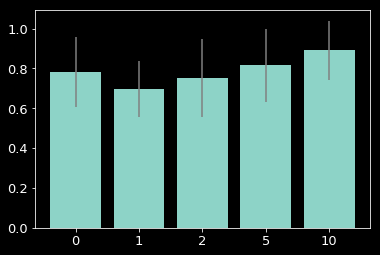

In [102]:
j = 1
plt.bar(range(len(dzs)), np.mean(vals[j],axis=1),yerr=np.std(vals[j],axis=1), error_kw=dict(ecolor='gray'))
plt.xticks(range(len(dzs)),dzs);

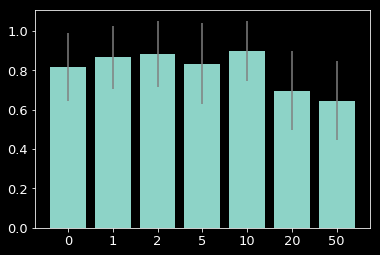

In [123]:
j = 1
plt.bar(range(len(dzs))[:-1], np.mean(vals[j],axis=1)[:-1],yerr=np.std(vals[j],axis=1)[:-1], error_kw=dict(ecolor='gray'))
plt.xticks(range(len(dzs))[:-1],dzs[:-1]);

([<matplotlib.axis.XTick at 0x7f01585f7cc0>,
 <a list of 9 Text xticklabel objects>)

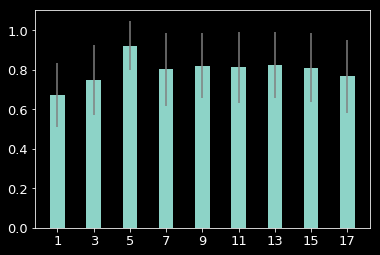

In [114]:
plt.bar(filter_sizes[:-1], np.mean(vals_conv,axis=1)[:-1],yerr=np.std(vals_conv,axis=1)[:-1], error_kw=dict(ecolor='gray'))
plt.xticks(filter_sizes[:-1])

([<matplotlib.axis.XTick at 0x7f043ef99a90>,
 <a list of 9 Text xticklabel objects>)

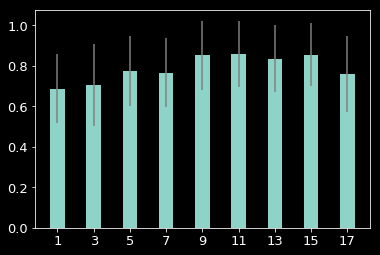

In [103]:
plt.bar(filter_sizes[:-1], np.mean(vals_conv,axis=1)[:-1],yerr=np.std(vals_conv,axis=1)[:-1], error_kw=dict(ecolor='gray'))
plt.xticks(filter_sizes[:-1])

In [194]:
filename = 'session1.pkl'
dill.load_session(filename)

#### Combined Bar Plot

Text(0.5,0,'Fully-Connected Network')

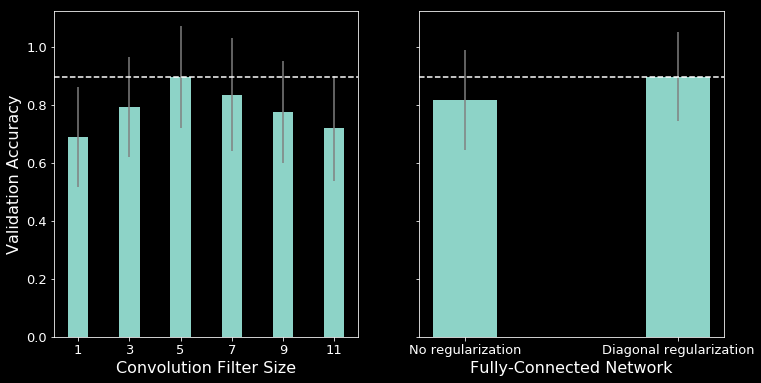

In [186]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=[12,6])

k = 4
ax1.bar(filter_sizes[:-k], 
        np.mean(vals_conv,axis=1)[:-k],
        yerr=np.std(vals_conv,axis=1)[:-k], 
        error_kw=dict(ecolor='gray'))

j = 1
ax1.axhline(np.mean(vals[j],axis=1)[4],linestyle='--',c='w')
ax1.set_xticks(filter_sizes[:-k]);
ax1.set_xlabel('Convolution Filter Size')
ax1.set_ylabel('Validation Accuracy')

ax2.bar([0,1], np.mean(vals[j],axis=1)[0:5:4],
        yerr=np.std(vals[j],axis=1)[0:5:4], error_kw=dict(ecolor='gray'), width=0.3)
ax2.axhline(np.mean(vals[j],axis=1)[4],linestyle='--',c='w')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['No regularization','Diagonal regularization']);
ax2.set_xlabel('Fully-Connected Network')

#### Visualize the Weights

0.985 0.985


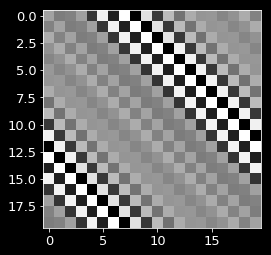

In [212]:
train, val, weight = general_network(data, kind='fully_connected',
                                      reg_kind='DZ+L1', reg_value=[10,1], 
                                      verbose=False,
                                      return_weights=True)
print(train,val)
plt.imshow(weight, cmap='gray', vmin=np.min(weight), vmax=np.max(weight))

# Meta Learning

In [ ]:
def general_network(data, num_channels=1, verbose=True, batches=1500, print_every=100, filter_size=5,
                    pool_to=1, return_weights=False, reg_kind=None, reg_value=None, kind='fully_connected'):
    
    tf.reset_default_graph()
    # input
    X_train, X_valid, y_train, y_valid = data
    d = X_train.shape[1]

    # placeholders
    x = tf.placeholder(tf.float32, [None, d])
    y_ = tf.placeholder(tf.float32, [None, 2])

    # weights
    if kind=='fully_connected':
        W_1 = get_variable([d, d*num_channels])
        b_1 = get_variable([d*num_channels])
    elif kind=='convolutional':
        W_1 = get_variable([filter_size, 1, num_channels])
        b_1 = get_variable([num_channels])   
    else:
        raise ValueError('Invalid kind of neural network')
    W_fc2 = get_variable([pool_to*num_channels, 2])
    b_fc2 = get_variable([2])
    
    # network
    if kind=='fully_connected':
        h = tf.nn.relu(tf.matmul(x, W_1) + b_1)
    elif kind=='convolutional':
        x_reshaped = tf.reshape(x, [-1, d, 1])
        h = tf.nn.conv1d(x_reshaped, W_1, 1, "SAME")
        
    h = tf.reshape(h, [-1, d*num_channels, 1, 1])
    h = tf.nn.max_pool(h, [1, d/pool_to, 1, 1], [1, d/pool_to, 1, 1], padding='SAME')
    h = tf.reshape(h, [-1, pool_to*num_channels])
    y = tf.matmul(h, W_fc2) + b_fc2

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    if kind=='fully_connected':
        loss = regularize(loss, W_1, reg_kind, reg_value)
    train_step = tf.train.AdamOptimizer(0.003).minimize(loss)

    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(batches):
            train_step.run(feed_dict={x: X_train, y_: y_train})
            if i%print_every==0:
                accuracy_train = accuracy.eval(feed_dict={x: X_train, y_: y_train})
                accuracy_valid = accuracy.eval(feed_dict={x: X_valid, y_: y_valid})
                if verbose:
                    print('Train acc:',accuracy_train, 'Valid acc:',accuracy_valid)
        
        return_values = [accuracy_train, accuracy_valid]
        if return_weights:
            return_values.append(sess.run(W_1))
        
    return return_values